In [2]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from evaluate import load as load_metric
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import text

In [5]:
df_1 = pd.read_csv("data/twcs.csv")
df_1.head(10)

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0
5,6,sprintcare,False,Tue Oct 31 21:46:24 +0000 2017,@115712 Can you please send us a private messa...,"5,7",8.0
6,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN
7,11,sprintcare,False,Tue Oct 31 22:10:35 +0000 2017,@115713 This is saddening to hear. Please shoo...,NaN,12.0
8,12,115713,True,Tue Oct 31 22:04:47 +0000 2017,@sprintcare You gonna magically change your co...,"11,13,14",15.0
9,15,sprintcare,False,Tue Oct 31 20:03:31 +0000 2017,@115713 We understand your concerns and we'd l...,12,16.0


In [7]:
# 60 row manual labels ive done
# 实际文件没有label column！
manual_labels = pd.read_csv("labels/labeled_sample_.csv") 

df_2 = df_1.merge(manual_labels[['text', 'label']], on="text", how="inner")
df_2.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,label
0,2665,116348,True,Tue Oct 31 23:06:51 +0000 2017,@AppleSupport Yes,2667,2664.0,NaN
1,11632,118243,True,Wed Nov 01 01:06:21 +0000 2017,@AppleSupport Yes,11634,11631.0,NaN
2,34581,123491,True,Wed Nov 01 14:03:55 +0000 2017,@AppleSupport Basically for a chat to be opene...,34582,34579.0,technical
3,35542,123754,True,Wed Nov 01 13:35:31 +0000 2017,@VirginAtlantic Trying to use their App to che...,35544,35541.0,NaN
4,36636,123981,True,Wed Nov 01 23:29:57 +0000 2017,@AppleSupport Freezing basically all of the ti...,36639,36634.0,NaN


In [ ]:
# TODO: 清洗步骤：图标反应出有大量的无意义词语，必须清洗！！！！！！！！！！

# Clean step
import re
def clean_text(txt):
    txt = txt.lower()
    txt = re.sub(r"http\S+", "", txt)        # remove URLs
    txt = re.sub(r"@\w+", "", txt)            # remove @handles
    txt = re.sub(r"[^a-z\s]", " ", txt)       # keep only letters and spaces
    txt = re.sub(r"\s+", " ", txt).strip()     # collapse multiple spaces
    return txt

df_2['clean_text'] = df_2['text'].astype(str).apply(clean_text)
df = df_2.dropna(subset=['label'])

In [6]:
stop_words = text.ENGLISH_STOP_WORDS.copy()

additional_stop_words = ['rt', 'https', 'co', 'my', 'i', 'the', 'to', 'and', 'is', 'for', 'you', 'but', 'we', 'that', 'this']
stop_words = stop_words.union(additional_stop_words)

tfidf = TfidfVectorizer(
    lowercase=True,
    token_pattern=r"(?u)\b\w+\b",
    max_features=1000
)

X = tfidf.fit_transform(df['clean_text'])
feature_names = np.array(tfidf.get_feature_names_out())

In [7]:
X_df = pd.DataFrame(X.toarray(), columns=feature_names)
X_df['label'] = df['label'].values

mean_tfidf = X_df.groupby('label').mean()

mean_tfidf.loc['technical'].head()

a               0.040185
able            0.054831
about           0.020804
access          0.000000
accidentally    0.000000
Name: technical, dtype: float64

/var/folders/yj/h7kmf_d53bbcgzkk3bl4tch00000gn/T/ipykernel_27526/2409655973.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top10.values, y=top10.index, palette="Blues_r")


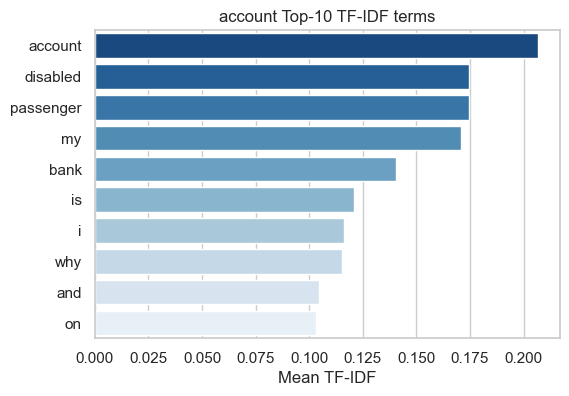

/var/folders/yj/h7kmf_d53bbcgzkk3bl4tch00000gn/T/ipykernel_27526/2409655973.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top10.values, y=top10.index, palette="Blues_r")


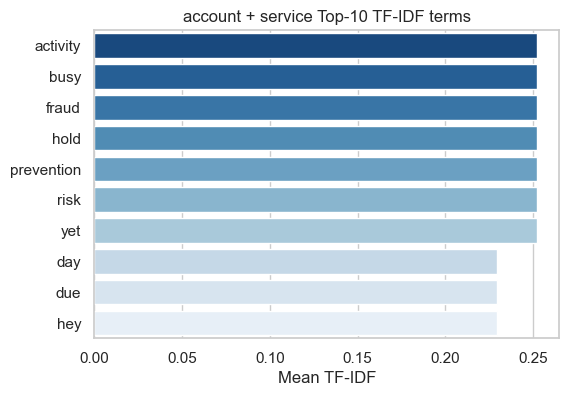

/var/folders/yj/h7kmf_d53bbcgzkk3bl4tch00000gn/T/ipykernel_27526/2409655973.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top10.values, y=top10.index, palette="Blues_r")


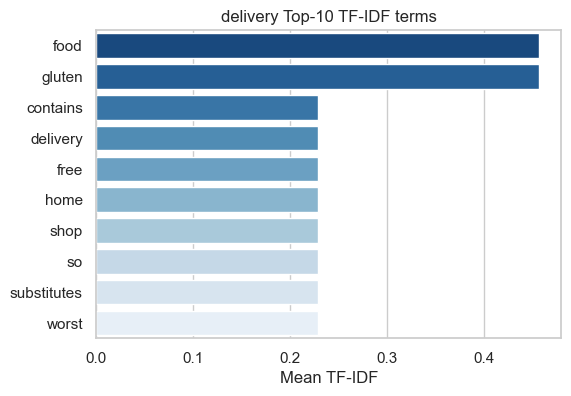

/var/folders/yj/h7kmf_d53bbcgzkk3bl4tch00000gn/T/ipykernel_27526/2409655973.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top10.values, y=top10.index, palette="Blues_r")


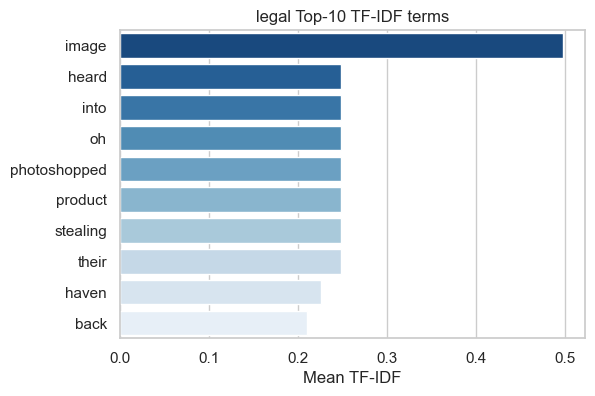

/var/folders/yj/h7kmf_d53bbcgzkk3bl4tch00000gn/T/ipykernel_27526/2409655973.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top10.values, y=top10.index, palette="Blues_r")


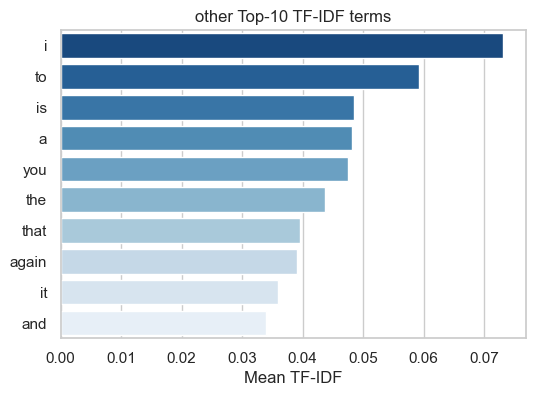

/var/folders/yj/h7kmf_d53bbcgzkk3bl4tch00000gn/T/ipykernel_27526/2409655973.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top10.values, y=top10.index, palette="Blues_r")


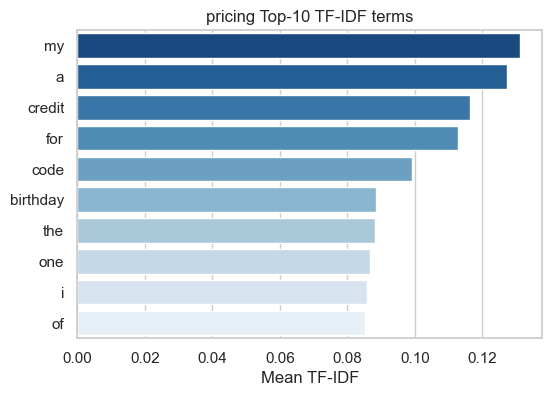

/var/folders/yj/h7kmf_d53bbcgzkk3bl4tch00000gn/T/ipykernel_27526/2409655973.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top10.values, y=top10.index, palette="Blues_r")


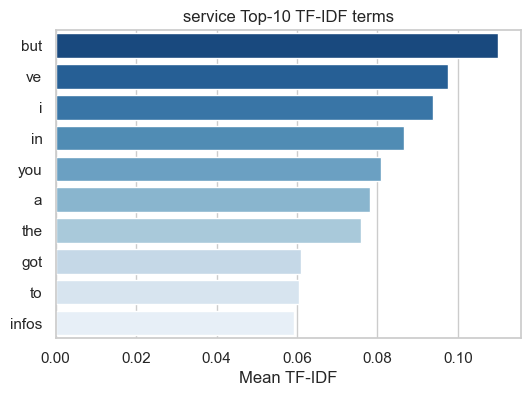

/var/folders/yj/h7kmf_d53bbcgzkk3bl4tch00000gn/T/ipykernel_27526/2409655973.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top10.values, y=top10.index, palette="Blues_r")


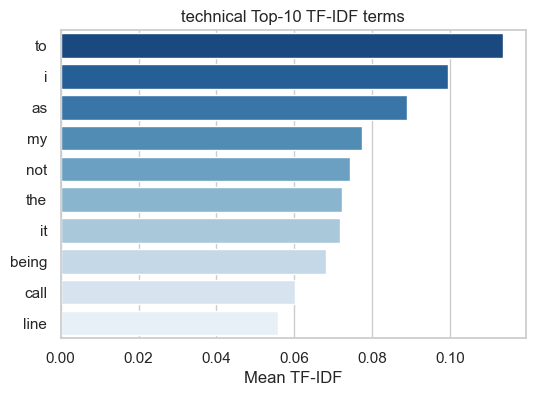

In [8]:
labels = mean_tfidf.index.tolist()

# Use seaborn
# seaborn styles: white, dark, whitegrid, darkgrid, ticks
sns.set_theme(style="whitegrid")  # correct seaborn API

for lbl in labels:
    row = mean_tfidf.loc[lbl]
    top10 = row.nlargest(10)
    plt.figure(figsize=(6, 4))
    sns.barplot(x=top10.values, y=top10.index, palette="Blues_r")
    plt.title(f"{lbl} Top-10 TF-IDF terms")
    plt.xlabel("Mean TF-IDF")
    plt.ylabel("")
    plt.show()

# n_labels = len(labels)
# fig, axes = plt.subplots(n_labels, 1, figsize=(8, 4 * n_labels))
#
# for ax, lbl in zip(axes, labels):
#     # 取该标签行中值最大的 10 个特征
#     row = mean_tfidf.loc[lbl]
#     top10 = row.nlargest(10)
#     # 横向条形图（倒序显示）
#     ax.barh(top10.index[::-1], top10.values[::-1])
#     ax.set_title(f"Label = {lbl} 的 Top 10 关键词")
#     ax.set_xlabel("Mean TF-IDF")
#     ax.tick_params(axis='y', labelsize=10)
# plt.tight_layout()
# plt.show()


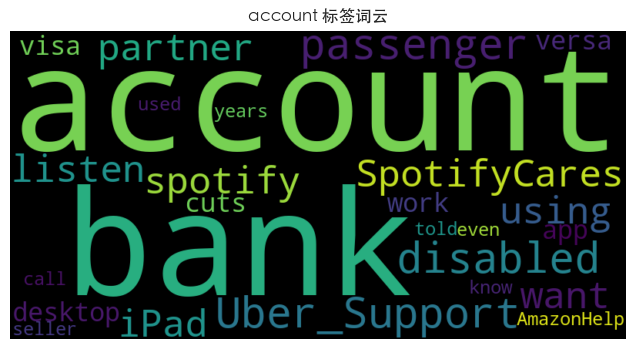

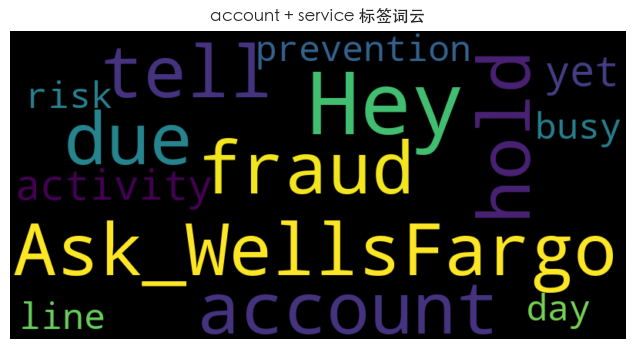

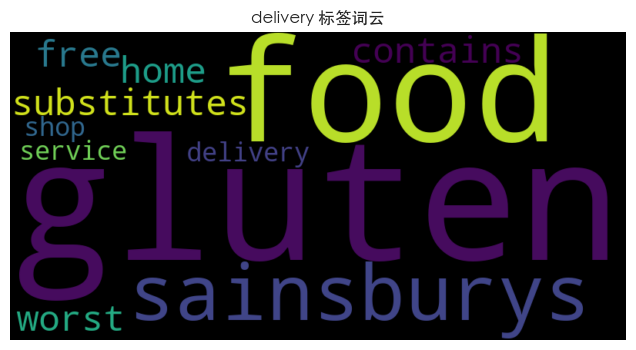

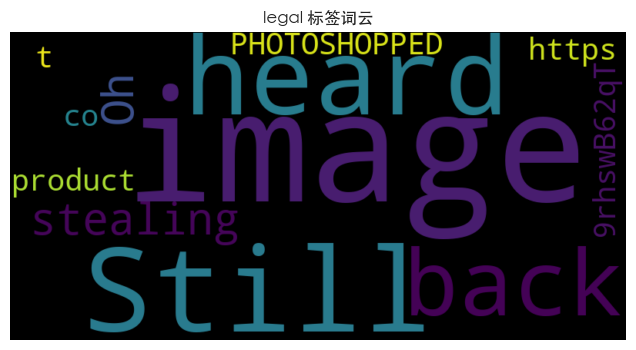

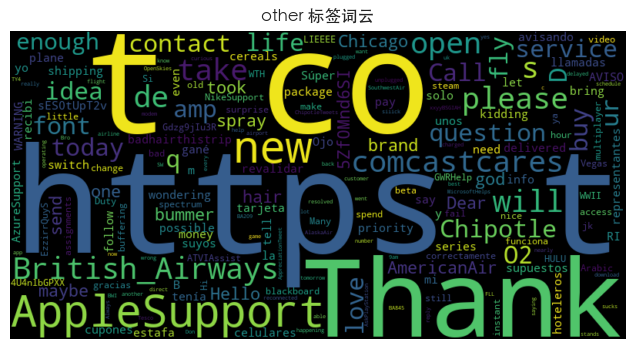

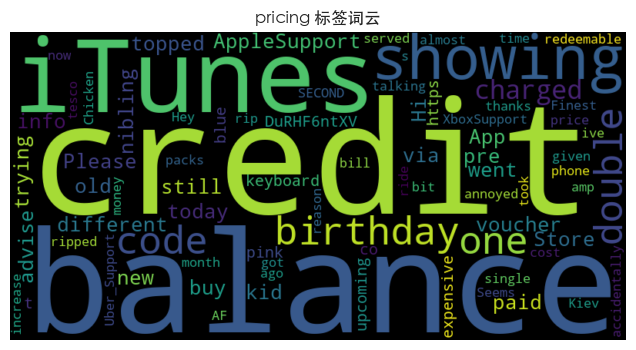

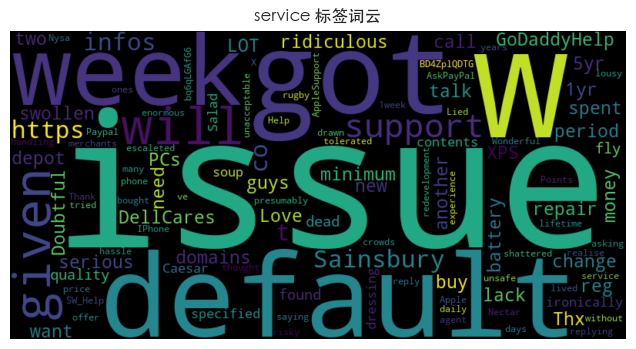

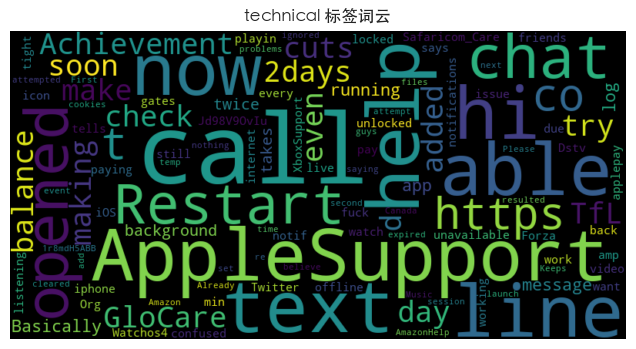

In [9]:
from wordcloud import WordCloud

for lbl in labels:
    text = " ".join(df[df['label']==lbl]['text'])
    wc = WordCloud(width=800, height=400).generate(text)
    plt.figure(figsize=(10,4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.rcParams['font.sans-serif'] = ['SimHei', 'STHeiti']
    plt.title(f"{lbl} 标签词云")
    plt.show()